# SNAP Gap in Los Angeles County: Spatial Patterns and Predictors
#### Meaghan Woody

### Part 3: Predictors of SNAP Gap Using Random Forests

What are the most important predictors of SNAP gap for LA County and for each SPA? Referring back to the table of variables pulled from the ACS 2023, I will use a random forests model trained on tract-level ACS data to investigate the importance of a set of demographic, socioeconomic, and household predictors on SNAP Gap.

Prepare Random Forests

In [8]:
import geopandas as gpd
snap_tracts = gpd.read_file("/Users/markwoody/Desktop/UP 213/UP213Final/final/data/snap_tracts_exp.gpkg")

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Specify x and y
xvars = [
    'avg_hh_size',
    'median_income',
    '%_seniors',
    '%_hispanic',
    '%_black',
    '%_asian',
    '%_employed',
    '%_undergrad',
    '%_renters',
    '%_rent_burd',
    '%_no_int',
    '%_no_vehic',
    '%_foreignborn'
]

yvar = 'snap_ebne'

# Create a dataframe with no NaNs
df_to_fit = snap_tracts[xvars+[yvar]].dropna()

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

# initialize the random forest classifer object
rf = RandomForestRegressor(n_estimators = 50, random_state = 1)

# now fit the model
rf.fit(X_train, y_train)

# make predictions
y_pred = rf.predict(X_test)

6.954037072656293


Text(0, 0.5, 'Predicted SNAP Gap')

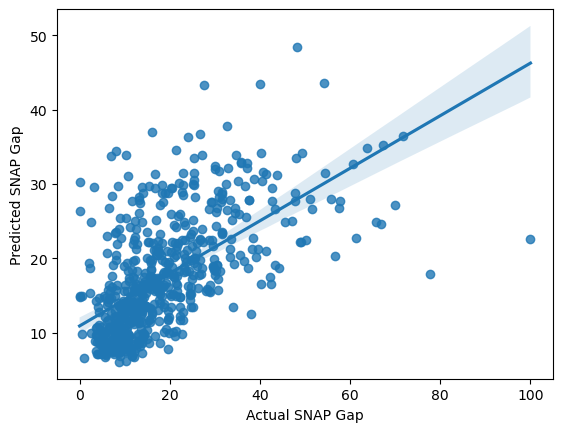

In [18]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

print(metrics.mean_absolute_error(y_test, y_pred))

fig, ax = plt.subplots()
sns.regplot(x=y_test, y=y_pred, ax=ax)
ax.set_xlabel('Actual SNAP Gap')
ax.set_ylabel('Predicted SNAP Gap')

In [26]:
# Label variables
col_labels = {
    'avg_hh_size': 'Average HH Size',
    'median_income': 'Median HH Income',
    '%_seniors': 'Population 65+ (%)',
    '%_hispanic': 'Hispanic (%)',
    '%_black': 'Black (%)',
    '%_asian': 'Asian (%)',
    '%_employed': 'Employed (%)',
    '%_undergrad': 'Undergr (%)',
    '%_renters': 'Renters (%)',
    '%_rent_burd': 'Rent Burdened>30% (%)',
    '%_no_int': 'HH w/o Internet (%)',
    '%_no_vehic': 'HH w/o Vehicle (%)',
    '%_foreignborn': 'Foreign-Born (%)'
}

Hispanic (%)
Average HH Size
Median HH Income
Rent Burdened>30% (%)
Renters (%)
Foreign-Born (%)
Black (%)
Population 65+ (%)
Undergr (%)
Employed (%)


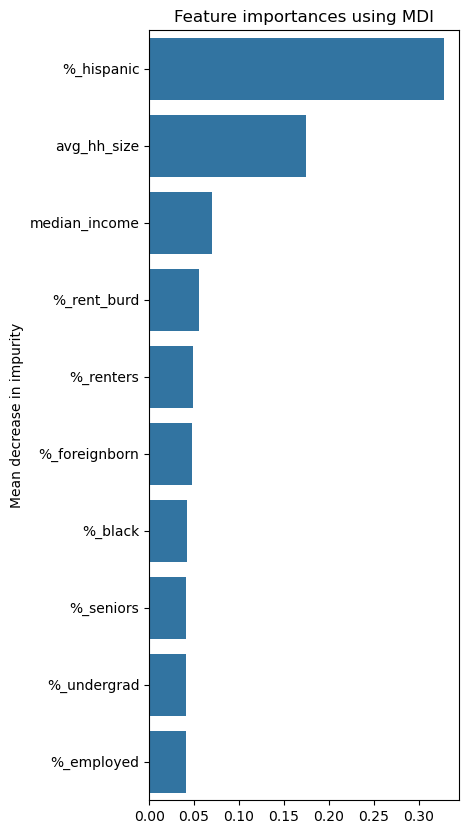

In [39]:
# code from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

import pandas as pd
import numpy as np
import seaborn as sns

importances = rf.feature_importances_

# convert to a series, and give the index labels from our X_train dataframe
forest_importances = pd.Series(importances, index=X_train.columns)

# sort the importances in descending order
forest_importances.sort_values(inplace=True, ascending=False)

# let's plot just the top 10

fig, ax = plt.subplots(figsize=(4,10))
sns.barplot(x=forest_importances.values[:10], y=forest_importances.index[:10], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

# let's find out what those variable are
# it would be better to actually change the axis tick label, but this is quick and dirty

for var in forest_importances.index.values[:10]:
    print(col_labels.get(var, var))  # fallback to the raw variable name if not found

### Random forests models for each SPA

SPA can be treated as a modifier, where we stratify the sample by each SPA area to see how the importances change with different local contexts.

In [43]:
import geopandas as gpd

# Import SPA boundaries 
spas = gpd.read_file('/Users/markwoody/Desktop/UP 213/UP213Final/final/data/Service_Planning_Areas_2022_view_8558881845522833049.zip')
spas = spas.to_crs(epsg=4326)
spas.head(7)

SPA         SPA_NAME ABBV  LABEL  SPA_NUM  \
0   1  Antelope Valley  ATV  SPA 1        1   
1   2     San Fernando  SFV  SPA 2        2   
2   3      San Gabriel  SGV  SPA 3        3   
3   4            Metro  MET  SPA 4        4   
4   5             West    W  SPA 5        5   
5   6            South    S  SPA 6        6   
6   7             East    E  SPA 7        7   

                                            geometry  
0  POLYGON ((-117.65523 34.39722, -117.65524 34.3...  
1  POLYGON ((-118.7659 34.75362, -118.77967 34.75...  
2  POLYGON ((-117.97228 34.43878, -117.9723 34.43...  
3  POLYGON ((-118.30434 34.15884, -118.30283 34.1...  
4  POLYGON ((-118.94469 34.045, -118.94463 34.045...  
5  POLYGON ((-118.34542 34.03996, -118.34471 34.0...  
6  MULTIPOLYGON (((-118.1741 33.81892, -118.17414...

In [58]:
# Spatial join 
tracts_spa = gpd.sjoin(snap_tracts, spas, how='left', predicate='within')
tracts_spa.head(1)

B05002_021E B05002_013E B01001_002E B01001_026E B01001_020E  \
GEOID                                                                     
06037101110         347        1608        2035        2117         101   

            B01001_021E B01001_022E B01001_023E B01001_024E B01001_025E  ...  \
GEOID                                                                    ...   
06037101110         120          55          50          63          16  ...   

            snap_rate median_income avg_hh_size  \
GEOID                                             
06037101110  45.79288       84091.0         2.6   

                                                      geometry index_right  \
GEOID                                                                        
06037101110  MULTIPOLYGON (((-118.30229 34.2587, -118.30091...         1.0   

            SPA      SPA_NAME ABBV  LABEL SPA_NUM  
GEOID                                              
06037101110   2  San Fernando  SFV  SPA 2     2.0  

[1 rows x 71 columns]

In [70]:
# Create subgroups for all 7 SPAs
spa_groups = {
    'Antelope Valley (SPA 1)': tracts_spa[tracts_spa['SPA_NUM'] == 1],
    'San Fernando (SPA 2)': tracts_spa[tracts_spa['SPA_NUM'] == 2],
    'San Gabriel (SPA 3)': tracts_spa[tracts_spa['SPA_NUM'] == 3],
    'Metro (SPA 4)': tracts_spa[tracts_spa['SPA_NUM'] == 4],
    'West (SPA 5)': tracts_spa[tracts_spa['SPA_NUM'] == 5],
    'South (SPA 6)': tracts_spa[tracts_spa['SPA_NUM'] == 6],
    'East (SPA 7)': tracts_spa[tracts_spa['SPA_NUM'] == 7]
}

Repeat the random forests model for all 7 SPAs through a loop

In [73]:
# Specify x and y
xvars = [
    'avg_hh_size',
    'median_income',
    '%_seniors',
    '%_hispanic',
    '%_black',
    '%_asian',
    '%_employed',
    '%_undergrad',
    '%_renters',
    '%_rent_burd',
    '%_no_int',
    '%_no_vehic',
    '%_foreignborn'
]

yvar = 'snap_ebne'

# Create a dataframe with no NaNs
df_to_fit = san_fernando[xvars+[yvar]].dropna()

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

# initialize the random forest classifer object
rf = RandomForestRegressor(n_estimators = 50, random_state = 1)

# now fit the model
rf.fit(X_train, y_train)

# make predictions
y_pred = rf.predict(X_test)

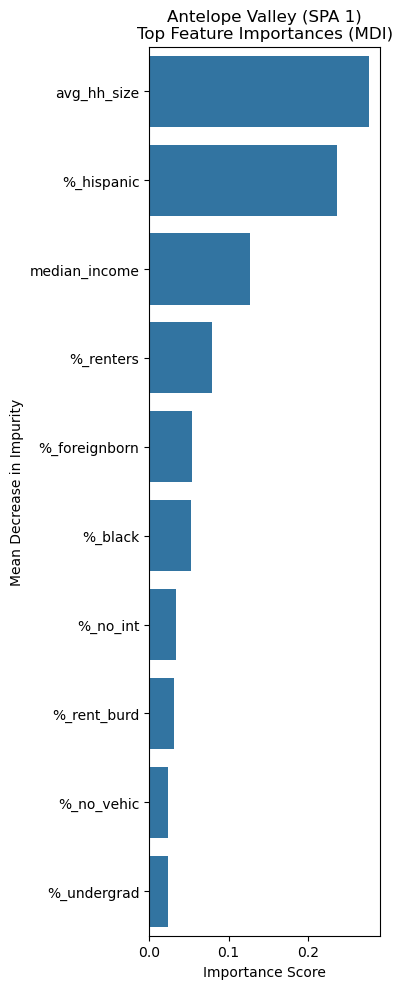


Top variables in Antelope Valley (SPA 1):
 - Average HH Size
 - Hispanic (%)
 - Median HH Income
 - Renters (%)
 - Foreign-Born (%)
 - Black (%)
 - HH w/o Internet (%)
 - Rent Burdened>30% (%)
 - HH w/o Vehicle (%)
 - Undergr (%)


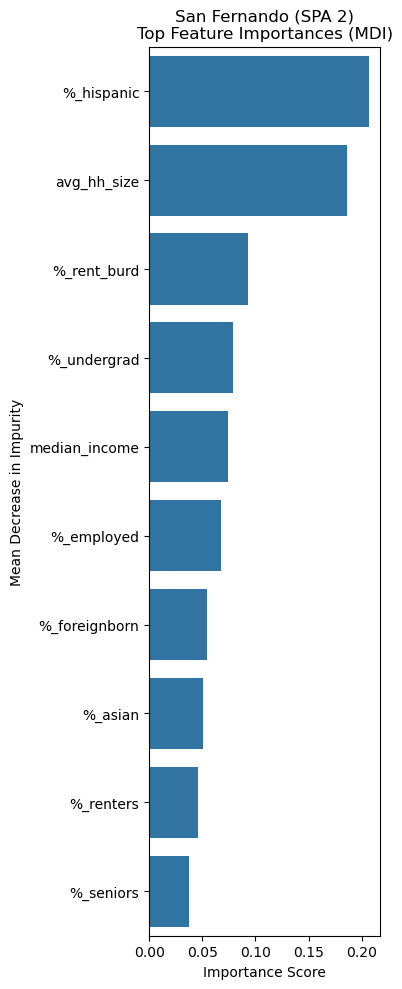


Top variables in San Fernando (SPA 2):
 - Hispanic (%)
 - Average HH Size
 - Rent Burdened>30% (%)
 - Undergr (%)
 - Median HH Income
 - Employed (%)
 - Foreign-Born (%)
 - Asian (%)
 - Renters (%)
 - Population 65+ (%)


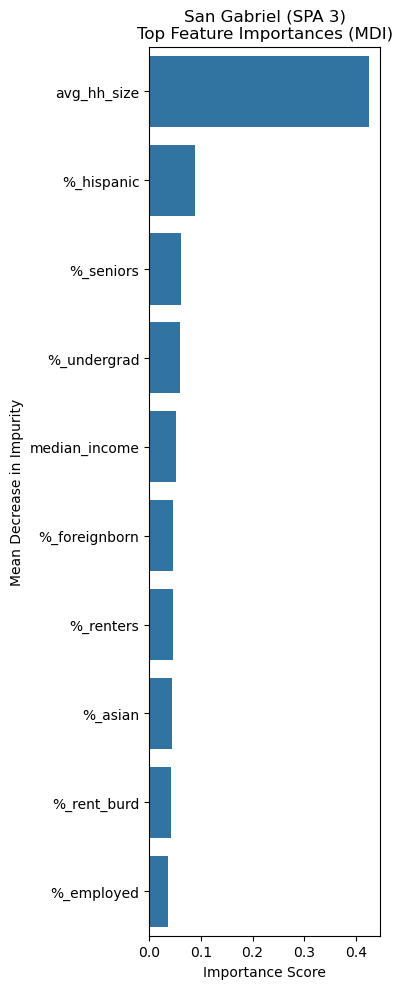


Top variables in San Gabriel (SPA 3):
 - Average HH Size
 - Hispanic (%)
 - Population 65+ (%)
 - Undergr (%)
 - Median HH Income
 - Foreign-Born (%)
 - Renters (%)
 - Asian (%)
 - Rent Burdened>30% (%)
 - Employed (%)


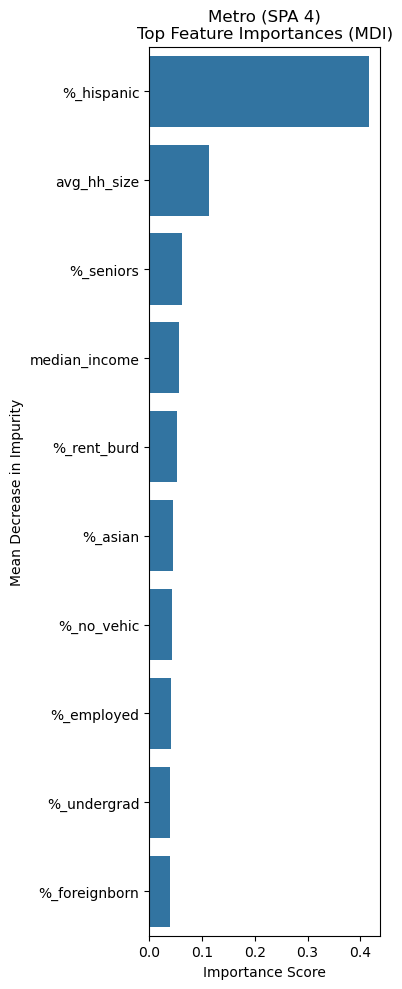


Top variables in Metro (SPA 4):
 - Hispanic (%)
 - Average HH Size
 - Population 65+ (%)
 - Median HH Income
 - Rent Burdened>30% (%)
 - Asian (%)
 - HH w/o Vehicle (%)
 - Employed (%)
 - Undergr (%)
 - Foreign-Born (%)


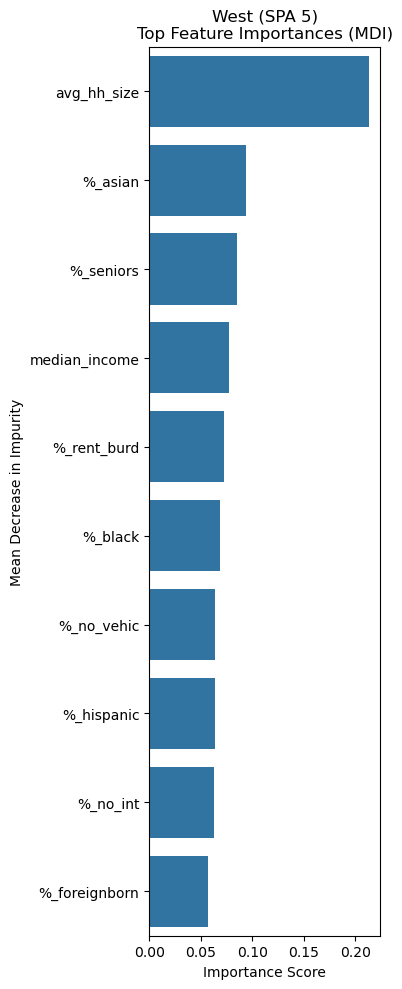


Top variables in West (SPA 5):
 - Average HH Size
 - Asian (%)
 - Population 65+ (%)
 - Median HH Income
 - Rent Burdened>30% (%)
 - Black (%)
 - HH w/o Vehicle (%)
 - Hispanic (%)
 - HH w/o Internet (%)
 - Foreign-Born (%)


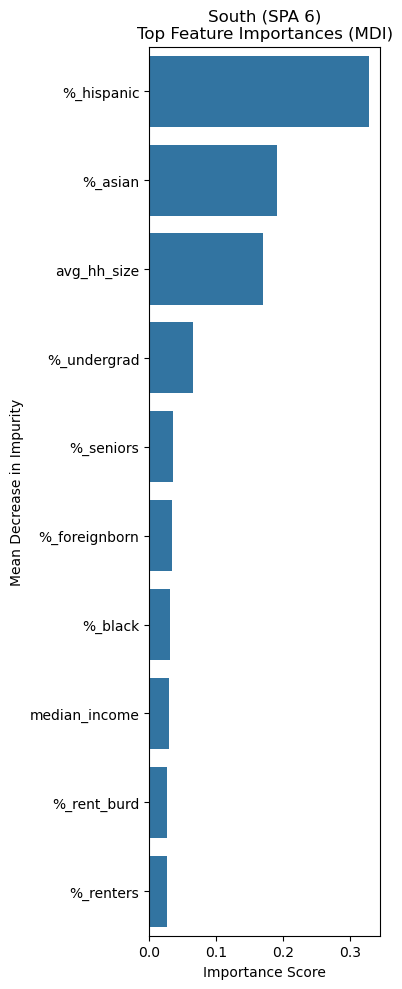


Top variables in South (SPA 6):
 - Hispanic (%)
 - Asian (%)
 - Average HH Size
 - Undergr (%)
 - Population 65+ (%)
 - Foreign-Born (%)
 - Black (%)
 - Median HH Income
 - Rent Burdened>30% (%)
 - Renters (%)


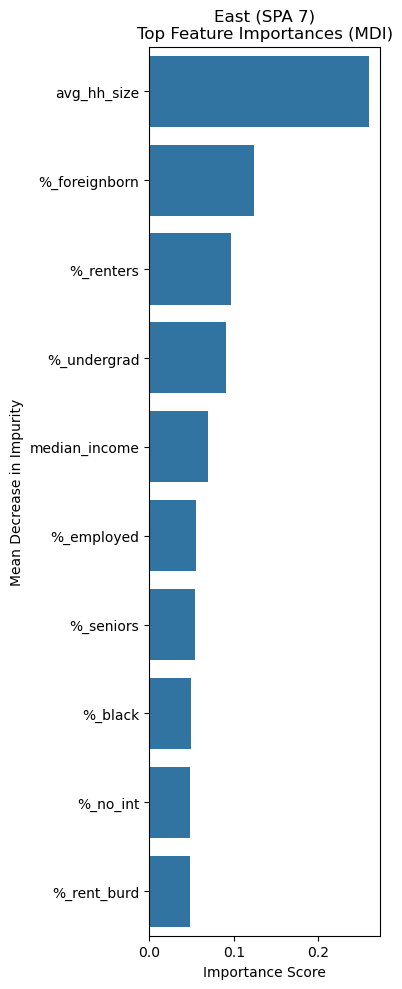


Top variables in East (SPA 7):
 - Average HH Size
 - Foreign-Born (%)
 - Renters (%)
 - Undergr (%)
 - Median HH Income
 - Employed (%)
 - Population 65+ (%)
 - Black (%)
 - HH w/o Internet (%)
 - Rent Burdened>30% (%)


In [77]:
for spa_name, spa_df in spa_groups.items():
    spa_df = spa_df.dropna(subset=xvars + ['snap_ebne'])  # drop missing
    
    X_spa = spa_df[xvars]
    y_spa = spa_df['snap_ebne']
    
    rf_spa = RandomForestRegressor(n_estimators=50, random_state=1)
    rf_spa.fit(X_spa, y_spa)
    
    importances = rf_spa.feature_importances_
    forest_importances = pd.Series(importances, index=X_spa.columns)
    forest_importances.sort_values(ascending=False, inplace=True)
    
    fig, ax = plt.subplots(figsize=(4, 10))
    sns.barplot(x=forest_importances.values[:10], y=forest_importances.index[:10], ax=ax)
    ax.set_title(f"{spa_name}\nTop Feature Importances (MDI)", fontsize=12)
    ax.set_ylabel("Mean Decrease in Impurity")
    ax.set_xlabel("Importance Score")
    plt.tight_layout()
    plt.show()

    print(f"\nTop variables in {spa_name}:")
    for var in forest_importances.index[:10]:
        print(" -", col_labels.get(var, var))